# MultiObjective GFlowNet Results
In this notebook, we present the MultiObjective GFlowNet results on the gridworlds. We present the following results:
1. Qualitative results of 3D objective function
2. Quantitative results on 3D objective function
3. Annealing  
4. Scaling results

### Import relevant packages  

In [89]:
!pip install seaborn
import grid_cond_gfn as gfn
import itertools
import torch
import matplotlib.pyplot as pp
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import pickle
import gzip
import numpy as np
import os
import scipy.stats as stats
from itertools import product
from collections import defaultdict 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from torch.distributions.categorical import Categorical

from matplotlib.pyplot import figure

top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

mpl.rc('image', cmap=newcmp)

def binavg(x, n=100, var=False, 
            bounds=False, logx=False):
    if len(x) < n:
        return np.linspace(0, len(x), len(x)), x, 0*x+1, 0 * x, np.stack([x, x]).T
    if logx:
        bins = np.logspace(0, np.log(len(x))/np.log(10), n)
        idx = np.digitize(np.arange(len(x)), bins)
    else:
        bins = np.linspace(0, len(x), n)
        idx = np.int32(np.linspace(0, n, len(x)+1))[:-1]
    counts = np.bincount(idx, minlength=n)
    _y = y = np.bincount(idx, x, minlength=n) / counts
    bins = bins[counts>0]
    y = y[counts>0]
    r = (bins, y, counts)
    if var:
        var = np.sqrt(np.bincount(idx, x**2, minlength=n) / np.bincount(idx, minlength=n) - _y**2)
        r += (var[counts>0], )
    if bounds:
        r += (np.float32([(x[idx==i].min(),x[idx==i].max()) for i in range(n) if counts[i] > 0]), ) 
    return r
 
def smooth_plot(x, n=100, fill_var=False, fill_minmax=False, logx=False, **kw):
    bins, y, counts, var, bounds = binavg(x, n, var=True, bounds=True, logx=logx)
    if 'bins' in kw:
        bins = kw.pop('bins')[counts>0]
    l, = pp.plot(bins, y, **kw)
    if fill_var:
        pp.fill_between(bins, y-var, y+var, alpha=0.25, color=l.get_c())
    elif fill_minmax:
        pp.fill_between(bins, bounds[:, 0], bounds[:, 1], alpha=0.25, color=l.get_c())
    return l

Defaulting to user installation because normal site-packages is not writeable


### Visualize the reward functions

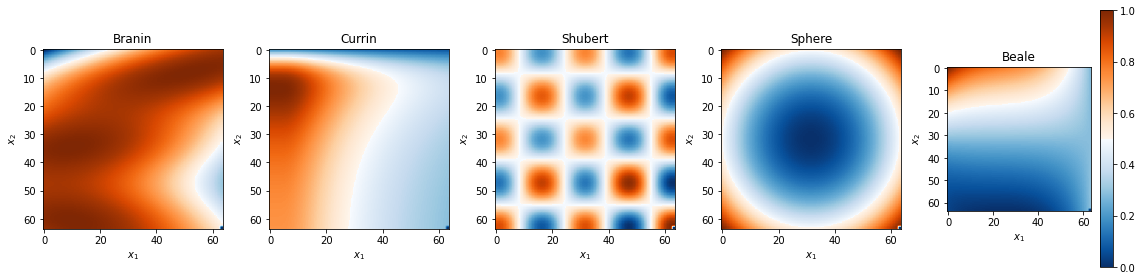

In [90]:
def get_functions(dims):
    functions = [gfn.branin, gfn.currin, gfn.shubert, gfn.sphere, gfn.beale]
    function_labels = ["Branin", "Currin", "Shubert", "Sphere", "Beale"]
    if dims == 3:
        return functions[:3], function_labels[:3]
    elif dims == 4:
        return functions[:4], function_labels[:4]
    else:
        return functions, function_labels

def visualize_reward():
    H = 64
    functions, function_labels = get_functions(dims=5)
    env = gfn.GridEnv(H, funcs=functions)
    s, r, pos = env.state_info()
    f, ax = pp.subplots(1,len(functions), figsize=(16,4))
    for i in range(len(functions)):
        pp.sca(ax[i])
        reward = r[:, i]
        pp.imshow(np.concatenate([reward, [0]]).reshape((H,H)))
        pp.xlabel('$x_1$')
        pp.ylabel('$x_2$')
        pp.title(function_labels[i])
    pp.colorbar()
    pp.tight_layout()
    pp.savefig("all_plots/rewards.png")
visualize_reward()

### Qualitative analysis of MO-GFN where we use a 3D objective function 

In this experiment, we use a three dimensional objective function so the reward vector for a given state $s \in \mathcal{S}$ looks like this: `R(s) = [Branin(s), Currin(s), Shubert(s)]`. We train a GFN where we condition the network on 1) Preference vectors $\omega = [\omega_1, \omega_2, \dots \omega_n]$ (where $n = 3$ in this specific case) and 2) Inverse temperature parameter $\beta$. 

**Aim:** The aim is to train the conditional GFN in such a way that we learn a density model proportional to the reward: $p(x|\omega, \beta) \propto R(x|\omega, \beta)$

#### Visualization of the true reward conditioned on temperature and preferences
As a first step, let's try to visualize how our reward function looks like conditioned on some preferences. Here, for visualization purposes, we randomly sample 10 preference vectors from dirichlet distribution. 

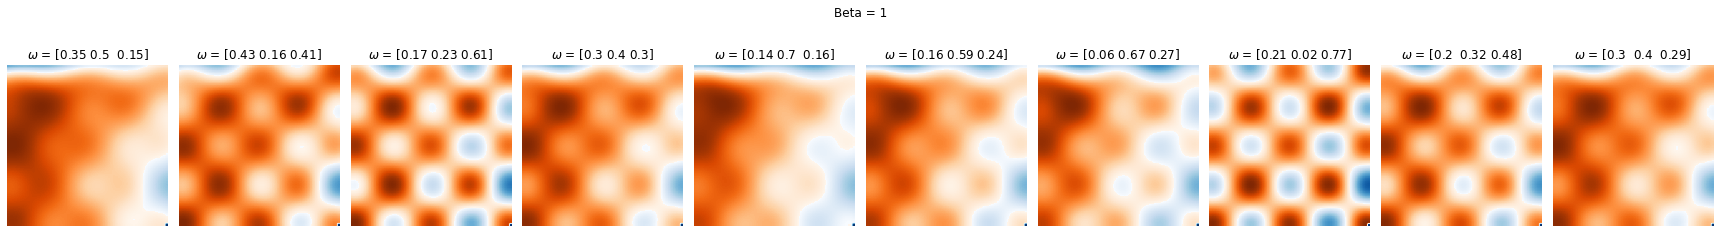

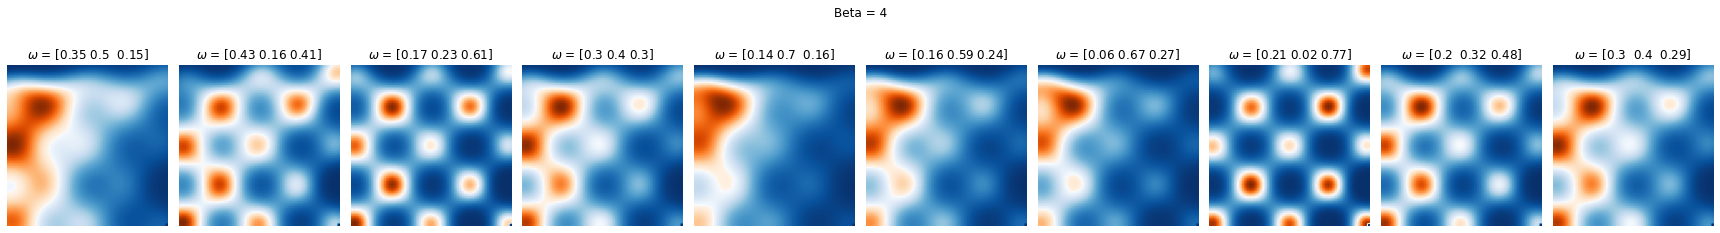

In [106]:
functions, _ = get_functions(dims=3)
preferences = np.random.dirichlet([1.5]*len(functions), size=10)
def reward_dist_with_preferences(preferences, beta, dims=3):
    H = 64
    env = gfn.GridEnv(64, funcs=functions)
    s, r, pos = env.state_info()
    f, ax = pp.subplots(1,preferences.shape[0], figsize=(24,4))
    for i in range(preferences.shape[0]):
        pp.sca(ax[i])
        y = 0
        for j in range(r.shape[-1]):
            y += r[:, j] * preferences[i, j]
        y = y ** beta
        pp.imshow(np.concatenate([y, [0]]).reshape((H,H)))
        pp.axis('off')
        pp.title(f'$\omega$ = {np.around(preferences[i], 2)}')
    pp.tight_layout()
    pp.suptitle("Beta = {}".format(beta))
    pp.savefig("conditional_rewards.png")
reward_dist_with_preferences(preferences, beta=1)
reward_dist_with_preferences(preferences, beta=4)

#### Results
Now lets visualize some of the qualitative results of MO-GFN. Here we train MOGFN conditioned on the preference vector and the inverse temperature parameter. We explore two different techniques to encode beta: 1) Identity Encoding  2) Thermometer Encoding. 

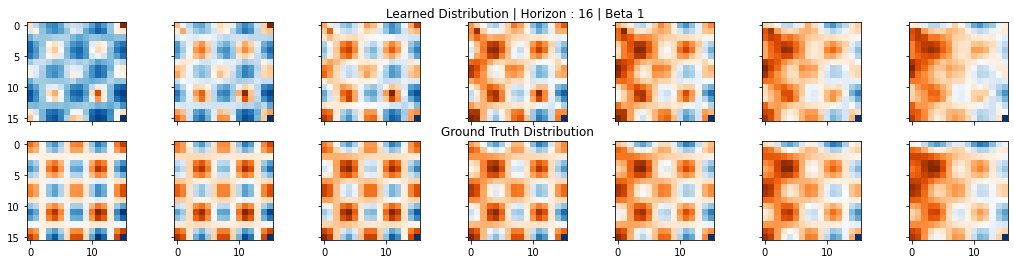

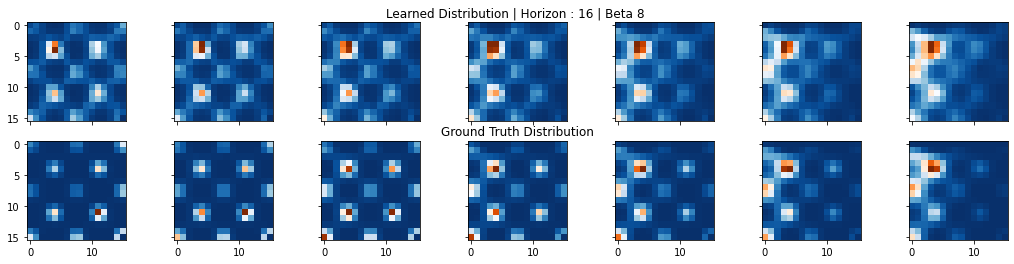

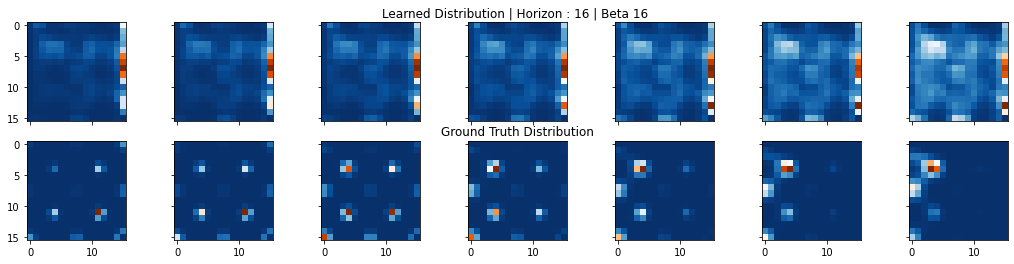

In [114]:
def plot_beta_evolution(horizon, dims, method, encoding):
    results = pickle.load(gzip.open(os.getcwd() + '/gridworld_results/results_final/{}/rewards_{}d/horizon_{}/results.pkl.gz'.format(method, dims, horizon), 'rb'))
    H = results['args'].horizon
    functions, _ = get_functions(dims)
    env = gfn.GridEnv(H, funcs=functions)
    s, r, pos = env.state_info()
    row = 0
    betas_idxs = [0, 3, 4]
    betas = [1, 8, 16]
    for idx, beta in enumerate(betas_idxs):
        f, ax = pp.subplots(2,7,figsize=(18,4), sharex=True, sharey=True)
        coefs = [] # This is a bad bad bad way of coding
        for col in range(7):
            coef, temp = results['cond_confs'][col * 5 + beta]
            coefs.append(coef)
            pp.sca(ax[0, col])
            if col == 3:
                pp.title("Learned Distribution | Horizon : {} | Beta {} ".format(H, betas[idx]))
            pp.imshow(np.concatenate([results['final_distribution'][:, col * 5 + beta], [0]]).reshape((H,H)))
            pp.sca(ax[1, col])
            if col == 3:
                pp.title("Ground Truth Distribution")
            pp.imshow(np.concatenate([(r[:, 0] * coef[0] + r[:, 1] * coef[1]+ r[:, 2] * coef[2])**temp, [0]]).reshape((H,H)))
        pp.savefig(os.getcwd() + '/plots/method_evol_horizon_{}_beta_{}_coefs_{}_v2.png'.format(horizon, betas[idx], coef))
    return coefs
_ = plot_beta_evolution(horizon=16, dims=3, method="const_2_1", encoding="identity")

**Observations:** We can see that the model is able to detect the modes decently but not that perfect. But lets also look at the loss curve to get some quantitative taste of the above results. Here we plot the loss curve where the loss is measured w.r.t to the true distribution. More specifically we take the absolute difference between the predicted distribution and true distribution across all preferences and betas and plot the average loss across the training.  



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


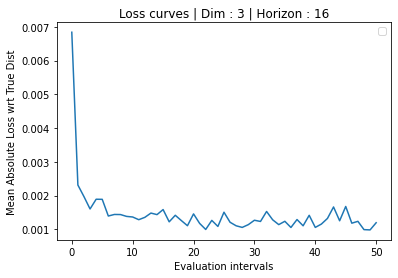

In [52]:
def plot_loss_curve(horizon, dims, method, encoding):
    if encoding == "thermo":
        results = pickle.load(gzip.open(os.getcwd() + '/results_thermo/{}_{}d_horizon_{}.pkl.gz'.format(method, dims, horizon), 'rb'))
    else:
        results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/{}_{}d_horizon_{}.pkl.gz'.format(method, dims, horizon), 'rb'))    
    functions, _ = get_functions(dims)
    env = gfn.GridEnv(horizon, funcs=functions)
    s, r, pos = env.state_info()
    data = results["true_losses"]
    pp.plot(data)
    pp.legend()
    pp.title("Loss curves | Dim : {} | Horizon : {}".format(dims, horizon))
    pp.xlabel("Evaluation intervals")
    pp.ylabel("Mean Absolute Loss wrt True Dist")
    pp.savefig("loss_curves_{}_{}_{}.png".format(method, dims, horizon))
plot_loss_curve(horizon=16, dims=3, method="const", encoding="identity")

This loss curve looks decent and predictable - as the training progresses, the average loss is decreasing. However this plot is not giving a complete picture of why the model is not performing well on some betas. 
From the qualitative results we can see that our model is struggling so the question now is can we do better?

To answer this question, let's look at how we are training the MO-GFN and more specifically how we are sampling the betas. For all of the above results we are sampling the beta value from a gamma distribution `Gamma(a, b)` with parameters `a = 2` and `b = 1`. One hypothesis could be that by using this sampling strategy for beta, it is diffcult for the model to see high beta values and hence the generalization is not so great! To verify this hypothesis, we can perform two useful experiments:

1. **Dirac Beta**: Fix the beta parameter throughout the traning. We are performing this experiment to test the models ability to capture peaks. Altough the model will likely fail to generalize to other beta's we are more interested to see if the model is capturing the peaks.
2. **Annealing**: We can perform "Annealing". Here the idea is to start with low beta values and slowly increase them during training. To do this, we change the shape parameter `a` in the gamma distribution while keeping `b=1`. 
3. **Uniform Sampling**: We can uniformly sample the betas. 

We show the qualitative and quantitative visualizations for MO-GFN trained with above sampling strategies for beta. 

##### Constant Beta Results

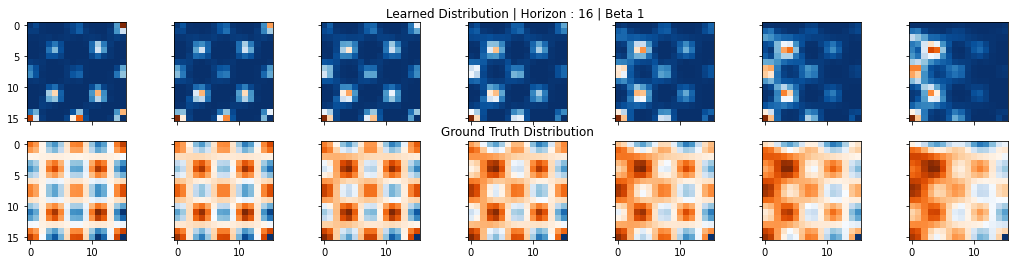

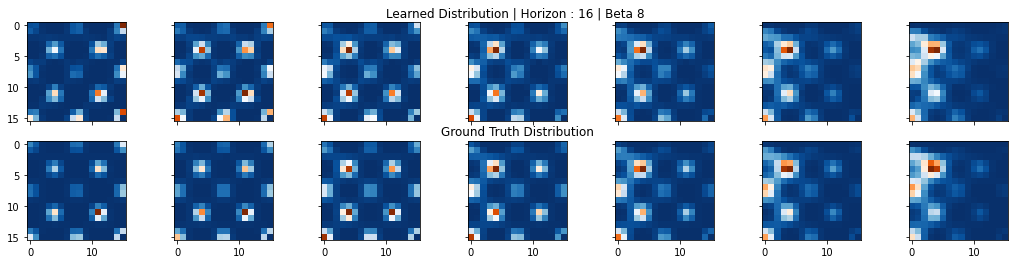

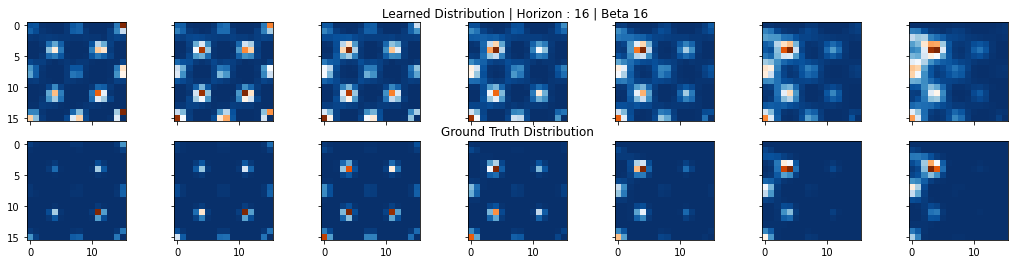

In [115]:
_ = plot_beta_evolution(horizon=16, dims=3, method="dirac/beta_8", encoding="identity")

##### Annealing Results

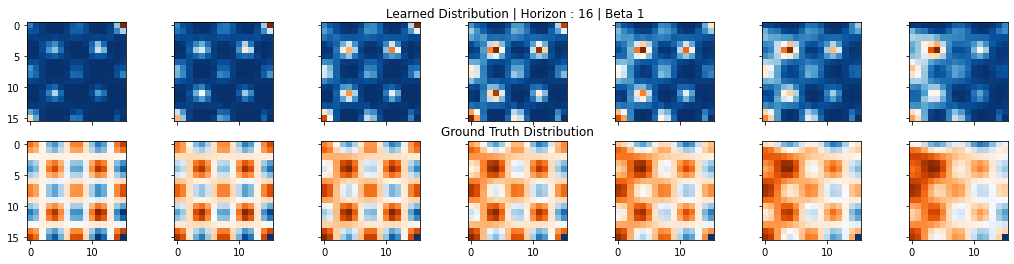

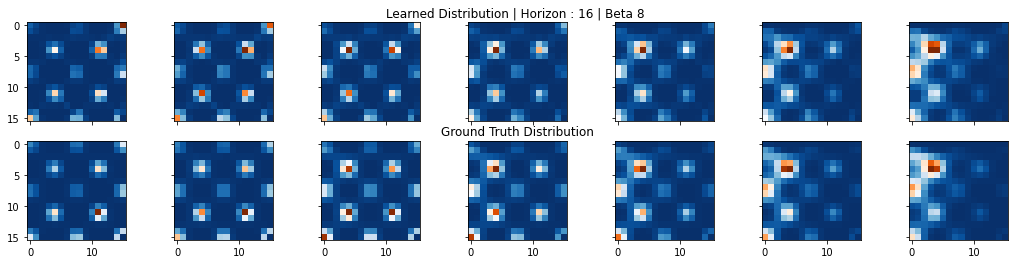

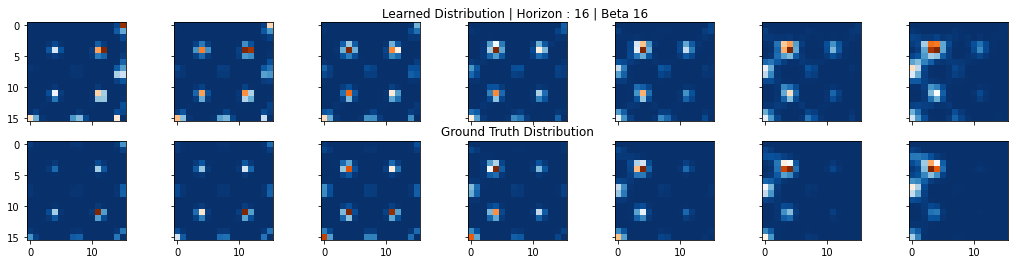

In [116]:
_ = plot_beta_evolution(horizon=16, dims=3, method="annealing", encoding="identity")

##### Uniform Sampling

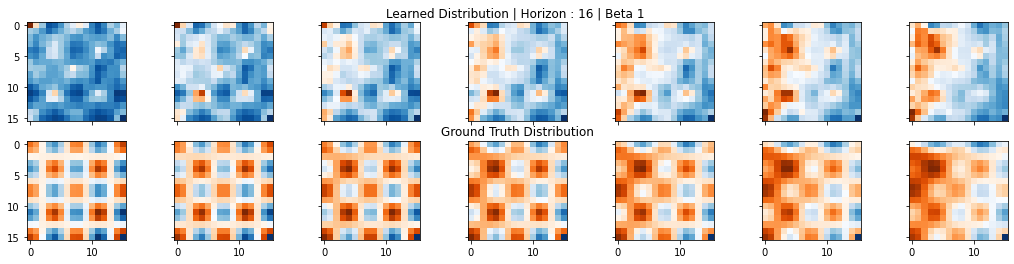

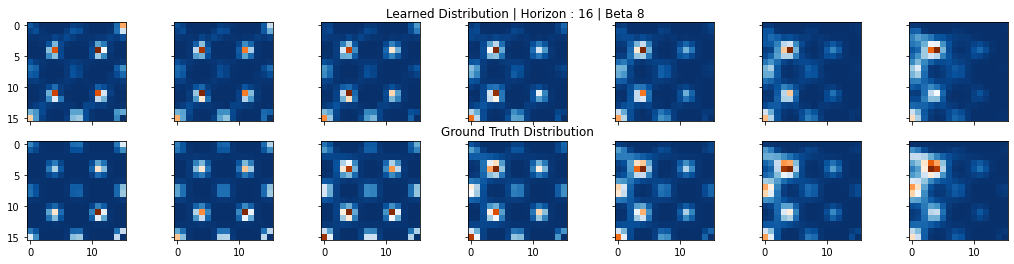

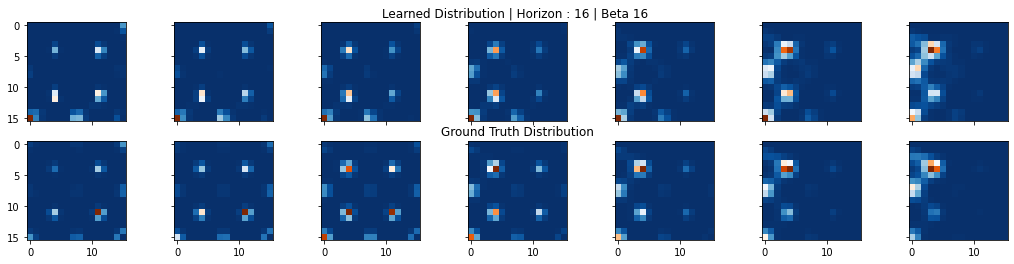

In [117]:
_ = plot_beta_evolution(horizon=16, dims=3, method="uniform", encoding="identity")

#### Loss curves

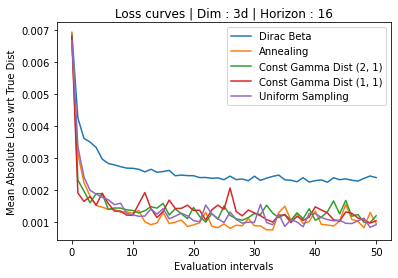

In [56]:
def get_loss_curves(horizon, dim, encoding):
    functions, _ = get_functions(3)
    files = [f"dirac_{dim}_horizon_{horizon}.pkl.gz", f"annealing_{dim}_horizon_{horizon}.pkl.gz", f"const_{dim}_horizon_{horizon}.pkl.gz", f"const_1_1_{dim}_horizon_{horizon}.pkl.gz", f"uniform_{dim}_horizon_{horizon}.pkl.gz"]
    x_labels = ["Dirac Beta", "Annealing", "Const Gamma Dist (2, 1)" , "Const Gamma Dist (1, 1)", "Uniform Sampling"]
    for idx, f in enumerate(files):
        if encoding=="thermo":
            results = pickle.load(gzip.open(os.getcwd() + '/results_thermo/' + f, 'rb'))
        else:
            results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/' + f, 'rb'))
        
        env = gfn.GridEnv(horizon, funcs=functions)
        s, r, pos = env.state_info()
        data = results["true_losses"]
        pp.plot(data, label=x_labels[idx])
    pp.legend()
    pp.title("Loss curves | Dim : {} | Horizon : {}".format(dim, horizon))
    pp.xlabel("Evaluation intervals")
    pp.ylabel("Mean Absolute Loss wrt True Dist")
    pp.savefig("loss_curves_{}_{}.png".format(dim, horizon))
get_loss_curves(horizon=16, dim="3d", encoding="identity")

**Observations**
1. From qualitative results, our hypothesis is verified and our model is indeed able to capture the modes with constant beta training.
2. Annealing and uniform sampling actually seems to help. The model is consistently capturing the modes across all betas. 
3. From the loss curves, annealing and uniform sampling seem to perform better on average than dirac beta. 


### Scaling Results
Now, lets analyze the scaling behavior of MO-GFNs where we scale the dimensions of the reward function. Here we scale from $3D$ to $5D$

In [32]:
def get_scaling_data():
    df = pd.DataFrame(columns=['Dimension', 'Method','Losses', 'Encoding'])
    dimensions = ["3d", "4d", "5d"]
    absolute = True
    functions = []
    for d in range(3, 6):
        funcs, _ = get_functions(d)
        functions.append(funcs)
    horizons = [16, 32, 64]
    for horizon in horizons:
        for dim_idx, dim in enumerate(dimensions):
            # "Const Gamma Dist"
            files = [ f"dirac_{dim}_horizon_{horizon}.pkl.gz", f"annealing_{dim}_horizon_{horizon}.pkl.gz", f"const_{dim}_horizon_{horizon}.pkl.gz", 
                    f"const_1_1_{dim}_horizon_{horizon}.pkl.gz", f"uniform_{dim}_horizon_{horizon}.pkl.gz"]

            x_labels = ["Dirac", "Annealing", "Gamma (2, 1)", "Gamma (1, 1)", "Uniform"]
            for idx, f in enumerate(files):
                if encoding=="Thermometer":
                    results = pickle.load(gzip.open(os.getcwd() + '/results_thermo/' + f, 'rb'))
                else:
                    results = pickle.load(gzip.open(os.getcwd() + '/resultsv3/' + f, 'rb'))
                env = gfn.GridEnv(horizon, funcs=functions[dim_idx])
                s, r, pos = env.state_info()

                errs = []
                logerrs = []
                for (coef, t), dist in zip(results['cond_confs'], results['final_distribution'].T):
                    unnorm_p = 0
                    for i in range(r.shape[-1]):
                        unnorm_p += r[:, i]*coef[i]

                    unnorm_p = unnorm_p ** t
                    Z = unnorm_p.sum()
                    p = unnorm_p / Z
                    errs.append(abs(dist - p).mean())

                loss = sum(errs) / len(errs)
                if not absolute:
                    if idx == 0:
                        dirac_lo ss = sum(errs) / len(errs)
                else:
                    dirac_loss = 1.0
                    # logp = np.log(unnorm_p) - np.log(Z)
                    # logerrs.append(abs(np.log(dist) - logp).mean())
                df = df.append({ 'Dimension' : dim, 'Method' : x_labels[idx], 'Losses' : loss / dirac_loss, 'Encoding': encoding, 'Horizon': horizon}, 
                        ignore_index = True)

    df.to_csv('scaling_plots_data.csv')
    return df
data = get_scaling_data()

   Dimension        Method    Losses     Encoding  Horizon
0         3d         Dirac  0.002438     Identity     16.0
1         3d     Annealing  0.000906     Identity     16.0
2         3d  Gamma (2, 1)  0.001303     Identity     16.0
3         3d  Gamma (1, 1)  0.001121     Identity     16.0
4         3d       Uniform  0.000926     Identity     16.0
5         4d         Dirac  0.002772     Identity     16.0
6         4d     Annealing  0.001123     Identity     16.0
7         4d  Gamma (2, 1)  0.001314     Identity     16.0
8         4d  Gamma (1, 1)  0.001284     Identity     16.0
9         4d       Uniform  0.000939     Identity     16.0
10        3d         Dirac  0.002115  Thermometer     16.0
11        3d     Annealing  0.000936  Thermometer     16.0
12        3d  Gamma (2, 1)  0.001169  Thermometer     16.0
13        3d  Gamma (1, 1)  0.001878  Thermometer     16.0
14        3d       Uniform   0.00069  Thermometer     16.0
15        4d         Dirac  0.002664  Thermometer     16

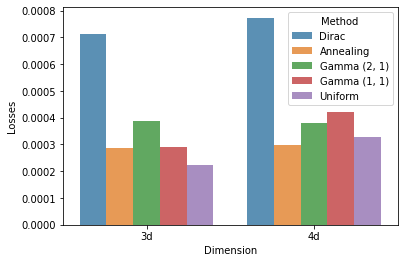

In [38]:
# df.pivot('Dimension', 'Method', 'Losses').plot(kind='bar')
my_encoding="Identity"
horizon=32
cond = (data["Encoding"] == my_encoding) & (data["Horizon"] == float(horizon))
new_df = data.loc[cond]
sns.barplot(x="Dimension", y="Losses", hue="Method", data=new_df, alpha=0.8)
pp.savefig("scaling_plots_dims_{}_{}_abs.png".format(horizon, my_encoding))

### Scaling w.r.t different beta encodings 

Till now we have show the results for "Identity Encoding" of beta. But we know that the raw encodings and neyral networks doesn't go too well. So lets try to encode beta in the laguage which NNs understand and see if it improves the performance. 


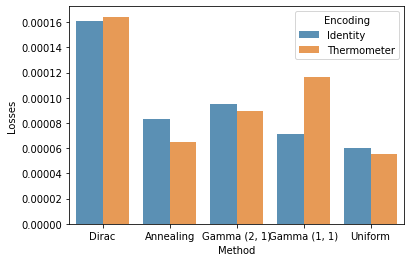

In [47]:
dim = "3d"
horizon=64
cond = (data["Dimension"] == dim) & (data["Horizon"] == float(horizon))
new_df = data.loc[cond]
sns.barplot(x="Method", y="Losses", hue="Encoding", data=new_df, alpha=0.8)
pp.savefig("scaling_plots_dims_{}_{}_abs.png".format(horizon, my_encoding))

## Effect of Temperature on Exploration

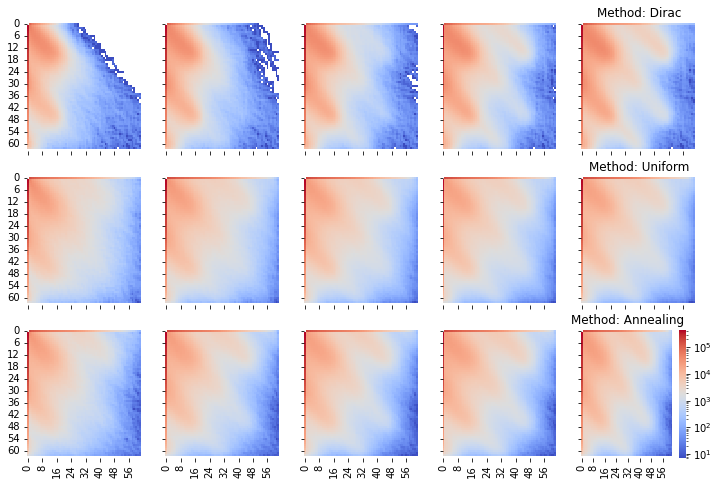

In [103]:
from matplotlib.colors import LogNorm, Normalize

methods = ["dirac/beta_16/","uniform", "annealing" ]
labels = ["Dirac", "Uniform", "Annealing" ]
horizons = ["64"]
rewards = [3]
checkpoints = [1000, 2000, 3000, 4000, 5000]
f, ax = pp.subplots(3, 5,figsize=(12,8), sharex=True, sharey=True)
for idx, method in enumerate(methods):
    for hor in horizons:
        for rew in rewards:
            
            for i, check in enumerate(checkpoints):
                file_path = os.getcwd() + f'/gridworld_results/results_final/{method}/rewards_{rew}d/horizon_{hor}/exploration_{check}.npy'
                exploration = np.load(file_path)
                pp.sca(ax[idx, i])
                if idx == len(methods) - 1 and i == len(checkpoints) -1:
                    cbar = True
                else:
                    cbar=False
                sns.heatmap(exploration, cbar=cbar, norm=LogNorm(), cmap="coolwarm")
#                 vmin=exploration.min(), vmax=exploration.max()
                # print(exploration.max(), exploration.min())
            pp.title(f"Method: {labels[idx]}")


## Pareto performance


In [104]:
# from pymoo.factory import get_performance_indicator
def get_pareto_front(reward):
    pareto = []
    re = reward.T
    for i in range(re.shape[1]):
        d = ((re[:, i, None] - re) < 0).prod(0).sum()
        if d == 0:
            pareto.append(re[:, i])
    pareto = np.float32(pareto)
    return pareto


In [105]:
def get_topk(envs, agent, coefficents, temperature, num_samples, k):
    data = []
    mbsize = 1
    for i in range(num_samples):
        s = torch.FloatTensor(np.float32([i.reset(coefs=coefficents[0], temp=temperature)[0] for i in envs]))
        done = [False] * mbsize
        while not all(done):
            print(s.shape)
            cat = Categorical(logits=agent(s))
            acts = cat.sample()
            ridx = torch.tensor((np.random.uniform(0,1,acts.shape[0]) < 0.01).nonzero()[0])
            if len(ridx):
                racts = np.random.randint(0, cat.logits.shape[1], len(ridx))
                acts[ridx] = torch.tensor(racts)
            logp = cat.log_prob(acts)
            step = [i.step(a) for i,a in zip([e for d, e in zip(done, envs) if not d], acts)]
            p_a = [envs[0].parent_transitions(sp_state, a == 2)
                   for a, (sp, r, done, sp_state) in zip(acts, step)]
            c = count(0)
            m = {j:next(c) for j in range(mbsize) if not done[j]}
            done = [bool(d or step[m[i]][2]) for i, d in enumerate(done)]
            s = tf(np.float32([i[0] for i in step if not i[2]]))
        for env in envs:
            data.append(env.s2r(env._state))
    data = np.array(data) # Shape: [preferences x number of samples]
    return data


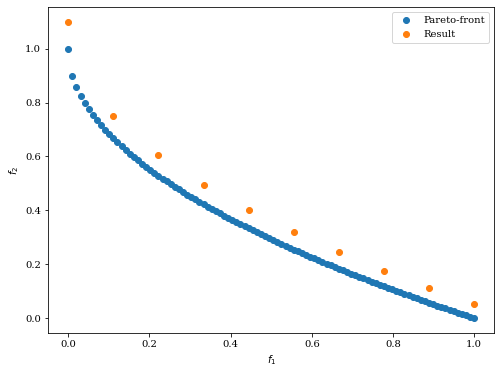

In [110]:
import numpy as np
from pymoo.factory import get_problem
from pymoo.visualization.scatter import Scatter

# The pareto front of a scaled zdt1 problem
pf = get_problem("zdt1").pareto_front()

# The result found by an algorithm
A = pf[::10] * 1.1

# plot the result
Scatter(legend=True).add(pf, label="Pareto-front").add(A, label="Result").show()


In [113]:
from pymoo.factory import get_performance_indicator
print(pf.shape, A.shape)
gd_plus = get_performance_indicator("gd+", pf)
print("GD+", gd_plus.do(A))


(100, 2) (10, 2)
GD+ 0.05497689467314528
